# Conectando a AWS S3
## Paso 1: credenciales aws

Se debe generar access key y secret en aws.

1 - Ingresar a la cuenta aws 

2 - Sobre el nombre de usuario que aparece en la parte superior derecha, Ir a My Security credentials

3 - Ir Access keys

4 - clic en "Create new access key" (se creará la llave)

5 - En el diálogo, hacer clic en "show access key" y copiar las credenciales (Access Key ID y Secret Access Key)

ejemplo:


    Access Key ID    : XXXXX
    Secret Access Key: YYYYY

Se recomienda descargar el archivo de respaldo, y guardar en un lugar seguro.

Una vez creada, la llave quedará activa.

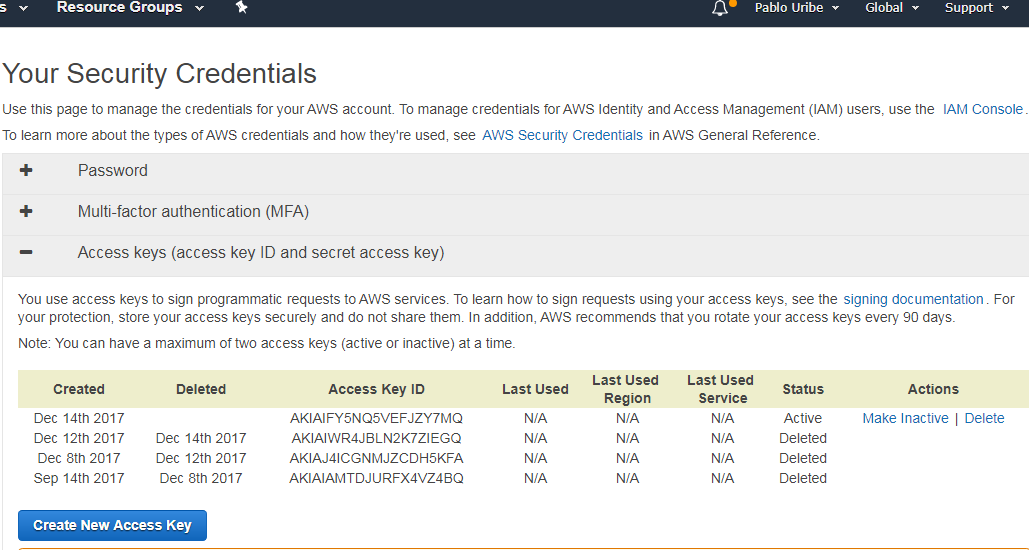

## Paso 2: crear conector en dsx

1 - Seleccionar del menú principal el menú Data Services -> Connections

2 - Clic en "Create New"

3 - Completar el formulario usando sus propios datos para access key

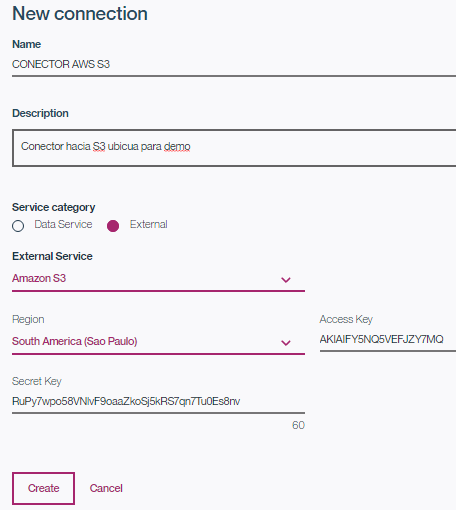

4 - clic en "create", el conector quedará disponible para ser usado desde el notebook. 

In [ ]:

from sklearn.ensemble import RandomForestClassifier
import pandas as pd


In [3]:
hconf = sc._jsc.hadoopConfiguration()  
hconf.set("fs.s3a.access.key", "xxx")  
hconf.set("fs.s3a.secret.key", "yyyyy") 

spark = SparkSession.builder.getOrCreate()  
df = spark.read.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat').option('header', 'true').option("delimiter",",").load('s3a://bluemixtest/REMOTE_PORTOUT_TRAIN_0.CSV')

In [4]:
#Convierto el dataframe a Panda SOLO PARA ARCHIVOS PEQUENOS
df = df.toPandas()
df.head(5) 

,ID,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,...,VAR_186,VAR_187,VAR_188,VAR_189,VAR_190,VAR_191,VAR_192,VAR_193,VAR_194,FL_TARGET
0,10003847,3941,1,38,1,1470,19990,0,0,0,...,1.000000,1.030000,0.930000,1.120000,0.820000,1.000000,1.120000,1.670000,1.670000,P
1,10019176,3945,1,38,1,1472,29990,0,0,0,...,1.000000,0.960000,0.770000,0.870000,0.770000,1.000000,0.870000,1.000000,1.000000,P
2,10019424,3945,1,38,1,1472,29990,0,0,0,...,1.000000,1.100000,0.910000,0.910000,0.970000,1.000000,0.910000,0.000000,0.000000,A
3,10022424,3835,3,38,1,1417,6990,0,0,0,...,1.000000,1.000000,0.990000,1.100000,1.000000,1.000000,1.060000,1.670000,1.670000,A
4,10023637,4473,3,38,1,1736,13990,0,0,0,...,1.000000,1.050000,0.750000,1.020000,0.700000,1.670000,1.040000,1.000000,1.000000,P


In [5]:
# 4. Divido en train y test
Y_TRAIN = df.FL_TARGET
X_TRAIN = df.drop('FL_TARGET', axis=1) #el target se debe quitar de la muestra

In [6]:
#inicializo el modelo
clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=2,
            oob_score=True, random_state=0, verbose=0, warm_start=False)
#uso el modelo
clf.fit(X_TRAIN, Y_TRAIN) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=2,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [7]:
#obtengo el archivo de test
df_test = spark.read.format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat').option('header', 'true').option("delimiter",",").load('s3a://bluemixtest/REMOTE_PORTOUT_TEST_0.CSV')


In [8]:
df_test = df_test.toPandas()
df_test.head(5) 

,ID,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,VAR_9,...,VAR_186,VAR_187,VAR_188,VAR_189,VAR_190,VAR_191,VAR_192,VAR_193,VAR_194,FL_TARGET
0,10000428,3979,5,40,1,1489,20990,12,17639,12,...,1.000000,1.000000,1.680000,0.640000,0.690000,0.640000,0.780000,1.030000,1.000000,A
1,10000485,4081,1,40,21,1540,9990,0,0,0,...,1.000000,1.000000,1.000000,1.350000,1.080000,1.360000,1.000000,1.290000,2.000000,A
2,1000075,4599,2,162,1,1799,29990,9,17639,6,...,0.220000,1.000000,0.940000,0.900000,0.450000,1.030000,2.000000,1.530000,1.000000,A
3,10001370,4599,6,40,1,1799,29990,17,17639,2,...,1.000000,1.000000,1.510000,1.040000,0.000000,1.300000,1.640000,1.430000,2.000000,A
4,1000199,4081,2,162,1,1540,9990,0,0,0,...,1.000000,1.000000,1.000000,1.230000,1.170000,1.180000,1.000000,0.940000,2.000000,A


In [9]:
#ejecuto el modelo contra la base test
X_TEST = df_test.drop('FL_TARGET', axis=1)
Y_TEST = df_test.FL_TARGET
PRED = clf.predict(X_TEST)
pd.crosstab(Y_TEST, PRED, rownames=['actual'], colnames=['preds'])

preds,A,P
actual,,
A,23447,2838
P,2120,850


In [10]:
#Precision del modelo
print("precisión del modelo: {0: .2f}".format((Y_TEST == PRED).mean()))

precisión del modelo:  0.83
